In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [31]:
dataset = pd.read_csv("data/cleaned_5250.csv")
missing_values_idx = dataset.isna().any(axis=1)
clean_dataset = dataset[~missing_values_idx]

In [32]:
num_obeservation = 4000
df = clean_dataset.iloc[range(num_obeservation)]
full_df = df.copy()
df = df.drop("name", axis=1)

In [33]:
# mass transformation: The dataset contains a mass calculation based on two planets. We unify that into a single mass variable
jupiter_mass_kg = 1.898 * 10**27 #kg
jupiter_radius_km = 69911 #km
earth_mass_kg = 5.972 * 10**24
earth_radius_km = 6378
df["mass_wrt"] = np.where(df["mass_wrt"] == "Jupiter", jupiter_mass_kg, earth_mass_kg)
df["mass"] = np.multiply(df["mass_multiplier"], df["mass_wrt"])
df["radius_wrt"] = np.where(df["radius_wrt"] == "Jupiter", jupiter_radius_km, earth_radius_km)
df["radius"] = np.multiply(df["radius_multiplier"], df["radius_wrt"])
df = df.drop(["mass_wrt", "radius_wrt", "mass_multiplier", "radius_multiplier"], axis=1)
print(df, df.shape)

      distance  stellar_magnitude   planet_type  discovery_year  \
0        304.0            4.72307     Gas Giant            2007   
1        409.0            5.01300     Gas Giant            2009   
2        246.0            5.23133     Gas Giant            2008   
3         58.0            6.61935     Gas Giant            2002   
4         69.0            6.21500     Gas Giant            1996   
...        ...                ...           ...             ...   
4260    7849.0           16.06200  Neptune-like            2016   
4261    3197.0           14.67200  Neptune-like            2016   
4262    2942.0           15.57600  Neptune-like            2016   
4263    3601.0           15.42400  Neptune-like            2016   
4264    3081.0           13.69300  Neptune-like            2016   

      orbital_radius  orbital_period  eccentricity detection_method  \
0           1.290000        0.892539          0.23  Radial Velocity   
1           1.530000        1.400000          0.08  R

In [34]:
outlier = df.iloc[np.where(df["mass"] > 10**30)]
df = df.drop(outlier.index)

In [35]:

planet_type = df["planet_type"]
encoded_df = df.copy()
#we encode the categorical variables, to make it digestable for the training stage later
encoded_df["detection_method"] = encoded_df["detection_method"].astype("category").cat.codes
encoded_df["planet_type"] = encoded_df["planet_type"].astype("category").cat.codes
encoded_df["discovery_year"] = encoded_df["discovery_year"].astype("category").cat.codes

#we have a separate df, so that the standardization is only done for the non-categorical variables
df_without_type = encoded_df.drop(["planet_type", "detection_method", "discovery_year"] , axis=1)

In [36]:
planet_cats = df["planet_type"].astype("category")
print(planet_cats.cat.categories) 
detection_cats = df["detection_method"].astype("category")
print(detection_cats.cat.categories)
discovery_cats = df["discovery_year"].astype("category")
print(discovery_cats.cat.categories) 


Index(['Gas Giant', 'Neptune-like', 'Super Earth', 'Terrestrial'], dtype='object')
Index(['Astrometry', 'Direct Imaging', 'Disk Kinematics',
       'Eclipse Timing Variations', 'Orbital Brightness Modulation',
       'Radial Velocity', 'Transit', 'Transit Timing Variations'],
      dtype='object')
Index([1995, 1996, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 2022, 2023],
      dtype='int64')


In [37]:
df_train = df_without_type.copy().drop("orbital_period", axis=1)
df_train["planet_type"] = df["planet_type"]
df_train = pd.get_dummies(df_train, columns=['planet_type'])

In [38]:
# Define features, and target variable
X = df_train.drop(columns=['mass']).values
y = df_train['mass'].values
print(X.shape, y.shape)

(3999, 9) (3999,)


In [39]:
def standardize_data(X_train_orig, X_test_orig, y_train_orig, y_test_orig, numerical_indices, encoded_indices):

    # Scale Numerical Features
    X_train_numerical = X_train_orig[:, numerical_indices]
    X_test_numerical = X_test_orig[:, numerical_indices]

    feature_scaler = StandardScaler()
    X_train_scaled_numerical = feature_scaler.fit_transform(X_train_numerical)
    X_test_scaled_numerical = feature_scaler.transform(X_test_numerical)

    # Recombine scaled numerical + encoded parts
    X_train_scaled = np.concatenate([X_train_scaled_numerical, X_train_orig[:, encoded_indices]], axis=1)
    X_test_scaled = np.concatenate([X_test_scaled_numerical, X_test_orig[:, encoded_indices]], axis=1)

    # Scale Target Variable
    mu_y = y_train_orig.mean()
    sigma_y = y_train_orig.std()
    epsilon = 1e-8

    y_train_scaled = (y_train_orig - mu_y) / (sigma_y + epsilon)
    y_test_scaled = (y_test_orig - mu_y) / (sigma_y + epsilon)

    return X_train_scaled.astype(np.float32), X_test_scaled.astype(np.float32), y_train_scaled, y_test_scaled, feature_scaler, mu_y, sigma_y


In [40]:
lambdas = np.logspace(-6, 4, 100)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

train_errors = []
test_errors = []
coeff = []

In [41]:
# Define column indices
total_columns = X.shape[1]
numerical_indices = list(range(total_columns - 4))
encoded_indices = list(range(total_columns - 4, total_columns))

# A safety check in case there are no numerical columns
has_numerical_features = len(numerical_indices) > 0

for lam in lambdas:
    
    fold_train_errors = []
    fold_test_errors = []
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Initialize processed arrays with the one-hot encoded parts
        X_train, X_test, y_train, y_test, a, b, c = standardize_data(
            X_train, X_test, y_train, y_test,
            numerical_indices, encoded_indices
        )

        # Fit the model on the correctly processed data
        ridge = Ridge(alpha=lam)
        ridge.fit(X_train, y_train)
        
        y_pred_train = ridge.predict(X_train)
        y_pred_test = ridge.predict(X_test)
        
        fold_train_errors.append(mean_squared_error(y_train, y_pred_train))
        fold_test_errors.append(mean_squared_error(y_test, y_pred_test))
    
    train_errors.append(np.mean(fold_train_errors))
    test_errors.append(np.mean(fold_test_errors))
    coeff.append(ridge.coef_)

/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.01057e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.33454e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.01057e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.33454e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.010

Optimal lambda = 3944.2061
Minimum Cross-Validation error = 0.9788
Optimal coefficients = [ 0.01481999 -0.0342379   0.02241286  0.04231808  0.12825069  0.05619033
 -0.03336674 -0.02012915 -0.00269449]


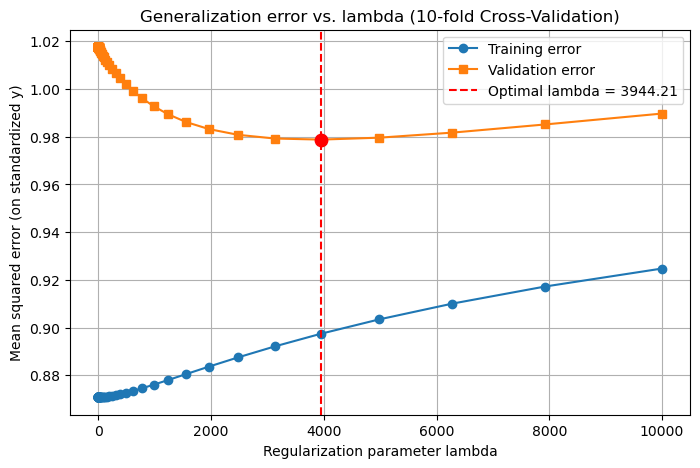

In [42]:
#optimal lambda
optimal_idx = np.argmin(test_errors)
optimal_lambda = lambdas[optimal_idx]
optimal_error = test_errors[optimal_idx]
optimal_coeff = coeff[optimal_idx]

print(f"Optimal lambda = {optimal_lambda:.4f}")
print(f"Minimum Cross-Validation error = {optimal_error:.4f}")
print(f"Optimal coefficients = {optimal_coeff}")
plt.figure(figsize=(8, 5))
plt.plot(lambdas, train_errors, marker='o', label='Training error')
plt.plot(lambdas, test_errors, marker='s', label='Validation error')

# Highlight optimal lambda
plt.axvline(optimal_lambda, color='red', linestyle='--', label=f'Optimal lambda = {optimal_lambda:.2f}')
plt.scatter(optimal_lambda, optimal_error, color='red', s=80, zorder=5)

# Labels and legend
plt.xlabel('Regularization parameter lambda')
plt.ylabel('Mean squared error (on standardized y)')
plt.title('Generalization error vs. lambda (10-fold Cross-Validation)')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
columns_to_log = ["distance", "orbital_period", "orbital_radius", "radius", "mass"]
for col in columns_to_log:
    df[col] = np.log10(df[col])

In [44]:

planet_type = df["planet_type"]
encoded_df = df.copy()
#we encode the categorical variables, to make it digestable for the training stage later
encoded_df["detection_method"] = encoded_df["detection_method"].astype("category").cat.codes
encoded_df["planet_type"] = encoded_df["planet_type"].astype("category").cat.codes
encoded_df["discovery_year"] = encoded_df["discovery_year"].astype("category").cat.codes

#we have a separate df, so that the standardization is only done for the non-categorical variables
df_without_type = encoded_df.drop(["planet_type", "detection_method", "discovery_year"] , axis=1)

In [45]:
df_train = df_without_type.copy().drop("orbital_period", axis=1)
df_train["planet_type"] = df["planet_type"]
df_train = pd.get_dummies(df_train, columns=['planet_type'])

In [46]:
# Define features, and target variable
X = df_train.drop(columns=['mass']).values
y = df_train['mass'].values
print(X.shape, y.shape)

(3999, 9) (3999,)


In [47]:
lambdas = np.logspace(-6, 2, 100)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

train_errors = []
test_errors = []
coeff = []

In [48]:
# Define column indices
total_columns = X.shape[1]
numerical_indices = list(range(total_columns - 4))
encoded_indices = list(range(total_columns - 4, total_columns))

# A safety check in case there are no numerical columns
has_numerical_features = len(numerical_indices) > 0

for lam in lambdas:
    
    fold_train_errors = []
    fold_test_errors = []
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Initialize processed arrays with the one-hot encoded parts
        X_train, X_test, y_train, y_test, a, b, c = standardize_data(
            X_train, X_test, y_train, y_test,
            numerical_indices, encoded_indices
        )

        # Fit the model on the correctly processed data
        ridge = Ridge(alpha=lam)
        ridge.fit(X_train, y_train)
        
        y_pred_train = ridge.predict(X_train)
        y_pred_test = ridge.predict(X_test)
        
        fold_train_errors.append(mean_squared_error(y_train, y_pred_train))
        fold_test_errors.append(mean_squared_error(y_test, y_pred_test))
    
    train_errors.append(np.mean(fold_train_errors))
    test_errors.append(np.mean(fold_test_errors))
    coeff.append(ridge.coef_)

/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.75012e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.89035e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.27471e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.63377e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.750

Optimal lambda = 0.9545
Minimum Cross-Validation error = 0.1049
Optimal coefficients = [ 0.03432924 -0.0333691   0.13701029  0.04212945  0.54578656  0.57035553
 -0.09589361 -0.07211914 -0.40484402]


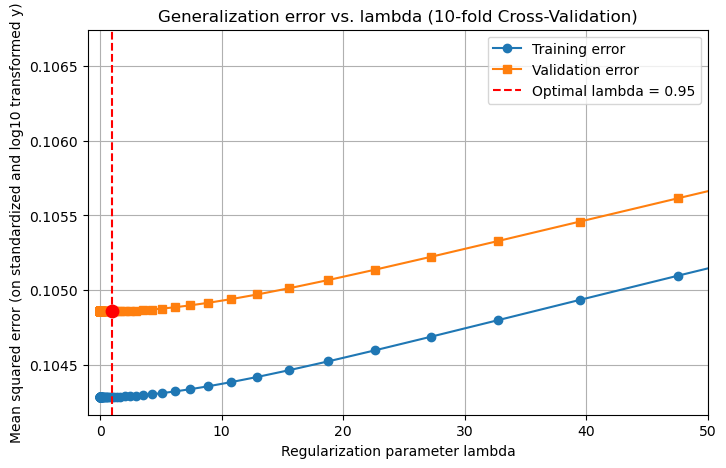

In [49]:
#optimal lambda
optimal_idx = np.argmin(test_errors)
optimal_lambda = lambdas[optimal_idx]
optimal_error = test_errors[optimal_idx]
optimal_coeff = coeff[optimal_idx]

print(f"Optimal lambda = {optimal_lambda:.4f}")
print(f"Minimum Cross-Validation error = {optimal_error:.4f}")
print(f"Optimal coefficients = {optimal_coeff}")

plt.figure(figsize=(8, 5))
plt.plot(lambdas, train_errors, marker='o', label='Training error')
plt.plot(lambdas, test_errors, marker='s', label='Validation error')

# Highlight optimal lambda
plt.axvline(optimal_lambda, color='red', linestyle='--', label=f'Optimal lambda = {optimal_lambda:.2f}')
plt.scatter(optimal_lambda, optimal_error, color='red', s=80, zorder=5)

# Labels and legend
plt.xlim(-1, 50)
plt.xlabel('Regularization parameter lambda')
plt.ylabel('Mean squared error (on standardized and log10 transformed y)')
plt.title('Generalization error vs. lambda (10-fold Cross-Validation)')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define the column indices for numerical and encoded features
total_columns = X.shape[1]
numerical_indices = list(range(total_columns - 4))
encoded_indices = list(range(total_columns - 4, total_columns))

# Isolate the numerical parts from the new splits
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, mu_y, sigma_y = standardize_data(
    X_train_orig, X_test_orig, y_train_orig, y_test_orig,
    numerical_indices, encoded_indices
)


print("--- Final Model Training ---")
print(f"Using optimal lambda: {optimal_lambda}")

# Initialize the model with the best lambda
ridge = Ridge(alpha=optimal_lambda)
ridge.fit(X_train_scaled, y_train_scaled)

# Store the final coefficients and intercept
coeffs = ridge.coef_
intercept = ridge.intercept_

# Make predictions on the scaled training and test sets
y_pred_train_scaled = ridge.predict(X_train_scaled)
y_pred_test_scaled = ridge.predict(X_test_scaled)

train_error_scaled = mean_squared_error(y_train_scaled, y_pred_train_scaled)
test_error_scaled = mean_squared_error(y_test_scaled, y_pred_test_scaled)

print(f"\nFinal training MSE (on scaled data): {train_error_scaled:.4f}")
print(f"Final test MSE (on scaled data): {test_error_scaled:.4f}")
print(f"\nModel Coefficients: {coeffs}")
print(f"Model Intercept: {intercept}")

--- Final Model Training ---
Using optimal lambda: 0.9545484566618347

Final training MSE (on scaled data): 0.0984
Final test MSE (on scaled data): 0.1221

Model Coefficients: [ 0.04580926 -0.0520371   0.13467312  0.04832492  0.5546862   0.5492336
 -0.083919   -0.05048667 -0.4118519 ]
Model Intercept: -0.08011260628700256


Ridge Regression Coefficients:
                 Feature  Coefficient
                  radius     0.554686
   planet_type_Gas Giant     0.549234
 planet_type_Terrestrial    -0.411852
          orbital_radius     0.134673
planet_type_Neptune-like    -0.083919
       stellar_magnitude    -0.052037
  planet_type_SuperEarth    -0.050487
            eccentricity     0.048325
                distance     0.045809

Intercept: -0.0801
Train Error (MSE): 0.0984
Test Error (MSE): 0.1221


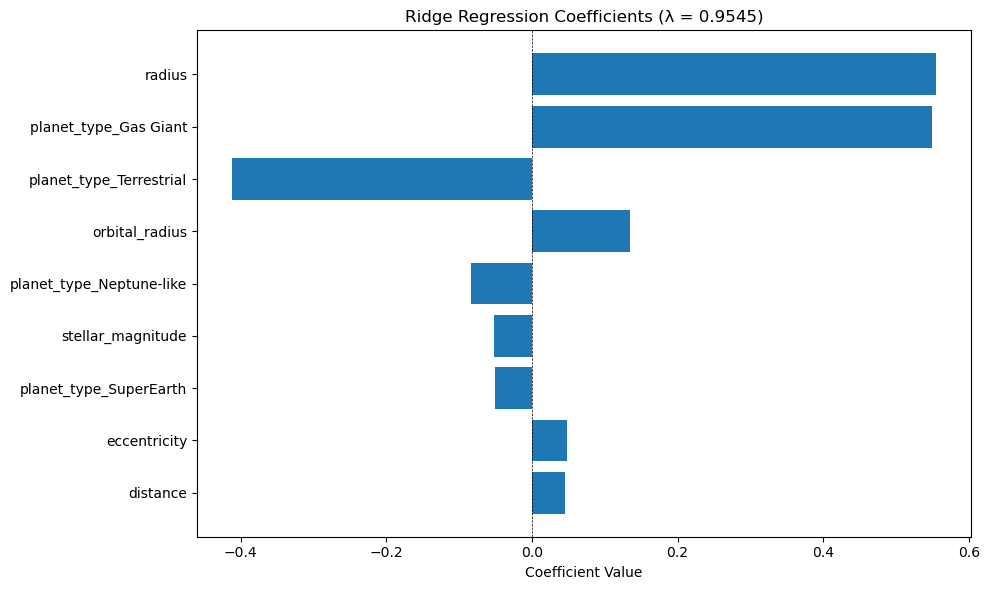

,Feature,Coefficient
4,radius,0.554686
5,planet_type_Gas Giant,0.549234
8,planet_type_Terrestrial,-0.411852
2,orbital_radius,0.134673
6,planet_type_Neptune-like,-0.083919
1,stellar_magnitude,-0.052037
7,planet_type_SuperEarth,-0.050487
3,eccentricity,0.048325
0,distance,0.045809


In [52]:


# Feature names for regression (excluding 'mass' which is the target)
feature_names_planets = ['distance', 'stellar_magnitude', 'orbital_radius', 'eccentricity', 'radius', 'planet_type_Gas Giant', 'planet_type_Neptune-like', 'planet_type_SuperEarth', 'planet_type_Terrestrial']
#feature_names = ['distance', 'stellar_magnitude', 'orbital_radius', 'eccentricity', 'radius']

# Create DataFrame for coefficients
coeffs_df = pd.DataFrame({
    'Feature': feature_names_planets,
    'Coefficient': coeffs
}).sort_values('Coefficient', key=abs, ascending=False)

print("Ridge Regression Coefficients:")
print(coeffs_df.to_string(index=False))
print(f"\nIntercept: {intercept:.4f}")
print(f"Train Error (MSE): {train_error_scaled:.4f}")
print(f"Test Error (MSE): {test_error_scaled:.4f}")

# Visualize coefficients
plt.figure(figsize=(10, 6))
plt.barh(coeffs_df['Feature'], coeffs_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title(f'Ridge Regression Coefficients (λ = {optimal_lambda:.4f})')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Display the DataFrame
coeffs_df

In [53]:
K1 = 10  # outer folds
K2 = 10  # inner folds

# Regularization and ANN hyperparameters
lambdas = np.logspace(-6, 2, 50)
hidden_units = [1, 8, 16, 32, 64, 128]

In [ ]:
# Storage
test_errors_outer = {
    'baseline': np.zeros(K1),
    'ridge': np.zeros(K1),
    'ann': np.zeros(K1),
}
y_true = []
y_preds = {
    'baseline': [],
    'ridge': [],
    'ann': [],
}

In [55]:
optimal_hs = np.zeros(K1)
optimal_hs_deep = np.zeros(K1)
optimal_lambdas = np.zeros(K1)

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class PredictorANN(nn.Module):
    def __init__(self, input_dim, hidden_units):
        super(PredictorANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, 1)
        )

    def forward(self, x):
        return self.model(x)

In [58]:
def train_custom_ann(X_train, y_train, X_val, y_val, hidden_units, 
                      lr=1e-8, weight_decay=0.0, epochs=10, batch_size=32, verbose=False, deep=False):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Convert numpy arrays to torch tensors
    
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32).to(device)
    X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_t = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32).to(device)

    # Datasets and loaders
    train_ds = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # Initialize model, loss, optimizer
    
    model = PredictorANN(X_train.shape[1], hidden_units).to(device)
        
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training loop
    model.train()
    for epoch in range(epochs):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
        step_val_loss = criterion(model(X_val_t), y_val_t).item()
        if verbose:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Val Loss: {step_val_loss:.4f}")

    # Validation
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_t)
        val_loss = criterion(val_preds, y_val_t).item()

    # print(f"Validation Loss: {val_loss:.4f}")
    return val_loss, model


In [59]:
# Outer cross-validation loop
from sklearn.neural_network import MLPRegressor


outer_cv = KFold(K1, shuffle=True, random_state=42)

for outer_fold, (outer_train_idx, outer_test_idx) in enumerate(outer_cv.split(X, y)):
    print(f"Outer fold {outer_fold + 1}/{K1}")

    X_train_outer, y_train_outer = X[outer_train_idx], y[outer_train_idx]
    X_test_outer, y_test_outer = X[outer_test_idx], y[outer_test_idx]

    # Standardize (based on training data)
    X_train_outer, X_test_outer, y_train_outer, y_test_outer, feature_scaler, mu_y, sigma_y = standardize_data(
        X_train_outer, X_test_outer, y_train_outer, y_test_outer,
        numerical_indices, encoded_indices
    )

    # BASELINE MODEL
    y_pred_baseline = np.full_like(y_test_outer, np.mean(y_train_outer))
    test_errors_outer['baseline'][outer_fold] = np.mean((y_test_outer - y_pred_baseline) ** 2)
    y_preds['baseline'].append(y_pred_baseline)

    #INNER CV for Ridge
    inner_cv = KFold(K2, shuffle=True, random_state=42)
    ridge_val_errors = np.zeros(len(lambdas))

    for i, lam in enumerate(lambdas):
        inner_errors = []
        for train_idx, val_idx in inner_cv.split(X_train_outer, y_train_outer):
            X_train_inner, X_val_inner = X_train_outer[train_idx], X_train_outer[val_idx]
            y_train_inner, y_val_inner = y_train_outer[train_idx], y_train_outer[val_idx]

            model = Ridge(alpha=lam)
            model.fit(X_train_inner, y_train_inner)
            y_val_pred = model.predict(X_val_inner)
            inner_errors.append(mean_squared_error(y_val_inner, y_val_pred))
        ridge_val_errors[i] = np.mean(inner_errors)

    optimal_lambda = lambdas[np.argmin(ridge_val_errors)]
    optimal_lambdas[outer_fold] = optimal_lambda

    # Train Ridge on full outer training set
    ridge_model = Ridge(alpha=optimal_lambda)
    ridge_model.fit(X_train_outer, y_train_outer)
    ridge_pred = ridge_model.predict(X_test_outer)
    ridge_test_error = np.mean((y_test_outer - ridge_pred) ** 2)
    test_errors_outer['ridge'][outer_fold] = ridge_test_error
    y_preds['ridge'].append(ridge_pred)

    # ----- INNER CV for ANN (PyTorch version) -----
    ann_val_errors = np.zeros(len(hidden_units))
    ann_val_errors_deep = np.zeros(len(hidden_units))

    for j, h in enumerate(hidden_units):
        inner_errors = []
        inner_errors_deep = []
        for train_idx, val_idx in inner_cv.split(X_train_outer, y_train_outer):
            X_train_inner, X_val_inner = X_train_outer[train_idx], X_train_outer[val_idx]
            y_train_inner, y_val_inner = y_train_outer[train_idx], y_train_outer[val_idx]

            val_loss, _ = train_custom_ann(X_train_inner, y_train_inner, X_val_inner, y_val_inner, hidden_units=h, 
                      lr=1e-3,epochs=20, batch_size=32, deep=False)
            inner_errors.append(val_loss)

            val_loss, _ = train_custom_ann(X_train_inner, y_train_inner, X_val_inner, y_val_inner, hidden_units=h, 
                      lr=1e-3,epochs=20, batch_size=32, deep=True)
            inner_errors_deep.append(val_loss)

        ann_val_errors[j] = np.mean(inner_errors)
        ann_val_errors_deep[j] = np.mean(inner_errors_deep)

    optimal_h = hidden_units[np.argmin(ann_val_errors)]
    optimal_hs[outer_fold] = optimal_h

    optimal_h_deep = hidden_units[np.argmin(ann_val_errors_deep)]
    optimal_hs_deep[outer_fold] = optimal_h_deep

    # Train final ANN model on full outer training set
    # _, ann_model = train_custom_ann(X_train_outer, y_train_outer, X_test_outer, y_test_outer,
    #                                 hidden_units=optimal_h, lr=1e-3, epochs=10)
    _, ann_model = train_custom_ann(X_train_outer, y_train_outer, X_test_outer, y_test_outer, hidden_units=optimal_h, 
                      lr=1e-3,epochs=20, batch_size=32, deep=False)
    ann_model.eval()

    device = next(ann_model.parameters()).device  # get model’s device
    X_test_t = torch.tensor(X_test_outer, dtype=torch.float32).to(device)
    y_test_t = torch.tensor(y_test_outer.reshape(-1, 1), dtype=torch.float32).to(device)

    with torch.no_grad():
        y_pred_t = ann_model(X_test_t).cpu().numpy().flatten()

    ann_test_error = mean_squared_error(y_test_outer, y_pred_t)
    test_errors_outer['ann'][outer_fold] = ann_test_error
    y_preds['ann'].append(y_pred_t)

    y_true.append(y_test_outer)


# Results summary
print("\nMean test errors across outer folds:")
for model_name, errors in test_errors_outer.items():
    print(f"{model_name:10s}: {np.mean(errors):.4f} ± {np.std(errors):.4f}")

Outer fold 1/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.58359e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.28952e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.58359e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.28952e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.583

Outer fold 2/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.89202e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.89202e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.89202e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.89202e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.892

Outer fold 3/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.7488e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.25908e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.63755e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.7488e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.25908

Outer fold 4/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.41775e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.53888e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.62365e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.41775e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.538

Outer fold 5/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.22505e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.22505e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.22505e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.22505e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.225

Outer fold 6/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.56726e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.01259e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=9.8127e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.56726e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.0125

Outer fold 7/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.34241e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.17396e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.34241e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.17396e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.342

Outer fold 8/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.07226e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.04531e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.12933e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.37591e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.497

Outer fold 9/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.46037e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.41526e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.12585e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.74494e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.460

Outer fold 10/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.23065e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=8.53469e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.79784e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.1798e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.5399


Mean test errors across outer folds:
baseline  : 1.0013 ± 0.0785
ridge     : 0.1049 ± 0.0179
ann       : 0.0898 ± 0.0167


In [60]:
y_true = np.concatenate(y_true)
y_preds_concat = {model: np.concatenate(model_preds) for model, model_preds in y_preds.items()}

In [61]:
# Summarize Results in Table
results_df = pd.DataFrame({
    'Fold': np.arange(1, K1 + 1),
    'lambda* (Ridge)': optimal_lambdas,
    'h* (ANN)': optimal_hs,
    'Baseline Test Error': test_errors_outer['baseline'],
    'Ridge Test Error': test_errors_outer['ridge'],
    'ANN Test Error': test_errors_outer['ann'],
})

# Display the table
print("\n===== Table 1: Cross-Validation Results =====")
print(results_df.to_string(index=False))

# Summary statistics
print("\nMean ± Std of Test Errors across folds:")
for model_name, errors in test_errors_outer.items():
    print(f"{model_name:10s}: {np.mean(errors):.4f} ± {np.std(errors):.4f}")


===== Table 1: Cross-Validation Results =====
 Fold  lambda* (Ridge)  h* (ANN)  Baseline Test Error  Ridge Test Error  ANN Test Error
    1         0.517947     128.0             0.931383          0.107760        0.094027
    2         1.098541     128.0             0.955037          0.137186        0.122456
    3         1.599859     128.0             1.147456          0.120906        0.107083
    4         1.098541     128.0             0.994241          0.116512        0.096391
    5         1.098541     128.0             0.968527          0.071089        0.060329
    6         0.754312     128.0             0.981940          0.098592        0.081771
    7         0.754312     128.0             0.924377          0.093092        0.081304
    8         0.000029     128.0             1.089606          0.084996        0.072183
    9         1.098541     128.0             1.104652          0.108283        0.087391
   10         1.599859      64.0             0.915483          0.110129  

In [62]:
import scipy.stats as st
def confidence_interval_comparison(y_true, y_preds_A, y_preds_B, loss_fn, alpha=0.05):
    z = loss_fn(y_true, y_preds_A) - loss_fn(y_true, y_preds_B)
    z_hat = np.mean(z)
    n = len(y_true)
    nu = n - 1  # degrees of freedom
    sem = np.sqrt(sum(((z - z_hat)**2) / (n * nu))) # or st.sem(loss_fn(y_true, y_preds))
    CI = st.t.interval(1 - alpha, df=nu, loc=z_hat, scale=sem)  # Confidence interval
    t_stat = -np.abs(np.mean(z)) / st.sem(z)
    p_value = 2 * st.t.cdf(t_stat, df=nu)  # p-value

    return z_hat, CI, p_value

In [63]:
l2_loss = lambda y, y_pred: (y - y_pred)**2
alpha = 0.05

setup1_storage = {
    'ridge_ann': [],
    'ann_baseline': [],
    'ridge_baseline': []
}

z_hat, CI, p_value = confidence_interval_comparison(y_true, y_preds_concat["ridge"], y_preds_concat["ann"], l2_loss, alpha=alpha)
setup1_storage['ridge_ann'].append((z_hat, CI, p_value))
print(f"Difference in loss between Ridge and ANN: \nz_hat: {z_hat:.4f}, \nCI: [{CI[0]:.4f}, {CI[1]:.4f}], \np-value: {p_value}")

z_hat, CI, p_value = confidence_interval_comparison(y_true, y_preds_concat["ridge"], y_preds_concat["baseline"], l2_loss, alpha=alpha)
setup1_storage['ridge_baseline'].append((z_hat, CI, p_value))
print(f"Difference in loss between Ridge and Baseline: \nz_hat: {z_hat:.4f}, \nCI: [{CI[0]:.4f}, {CI[1]:.4f}], \np-value: {p_value}")

z_hat, CI, p_value = confidence_interval_comparison(y_true, y_preds_concat["ann"], y_preds_concat["baseline"], l2_loss, alpha=alpha)
setup1_storage['ann_baseline'].append((z_hat, CI, p_value))
print(f"Difference in loss between ANN and Baseline: \nz_hat: {z_hat:.4f}, \nCI: [{CI[0]:.4f}, {CI[1]:.4f}], \np-value: {p_value}")

Difference in loss between Ridge and ANN: 
z_hat: 0.0150, 
CI: [0.0117, 0.0184], 
p-value: 9.1591604130588e-19
Difference in loss between Ridge and Baseline: 
z_hat: -0.8964, 
CI: [-0.9380, -0.8549], 
p-value: 1e-323
Difference in loss between ANN and Baseline: 
z_hat: -0.9115, 
CI: [-0.9536, -0.8693], 
p-value: 0.0


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [44]:
dataset = pd.read_csv("data/cleaned_5250.csv")
missing_values_idx = dataset.isna().any(axis=1)
clean_dataset = dataset[~missing_values_idx]
clean_dataset.shape

(4765, 13)

In [45]:
num_obeservation = 4000
df = clean_dataset.iloc[range(num_obeservation)]
full_df = df.copy()
df = df.drop("name", axis=1)

In [46]:
# mass transformation: The dataset contains a mass calculation based on two planets. We unify that into a single mass variable
jupiter_mass_kg = 1.898 * 10**27 #kg
jupiter_radius_km = 69911 #km
earth_mass_kg = 5.972 * 10**24
earth_radius_km = 6378
df["mass_wrt"] = np.where(df["mass_wrt"] == "Jupiter", jupiter_mass_kg, earth_mass_kg)
df["mass"] = np.multiply(df["mass_multiplier"], df["mass_wrt"])
df["radius_wrt"] = np.where(df["radius_wrt"] == "Jupiter", jupiter_radius_km, earth_radius_km)
df["radius"] = np.multiply(df["radius_multiplier"], df["radius_wrt"])
df = df.drop(["mass_wrt", "radius_wrt", "mass_multiplier", "radius_multiplier"], axis=1)
print(df, df.shape)

      distance  stellar_magnitude   planet_type  discovery_year  \
0        304.0            4.72307     Gas Giant            2007   
1        409.0            5.01300     Gas Giant            2009   
2        246.0            5.23133     Gas Giant            2008   
3         58.0            6.61935     Gas Giant            2002   
4         69.0            6.21500     Gas Giant            1996   
...        ...                ...           ...             ...   
4260    7849.0           16.06200  Neptune-like            2016   
4261    3197.0           14.67200  Neptune-like            2016   
4262    2942.0           15.57600  Neptune-like            2016   
4263    3601.0           15.42400  Neptune-like            2016   
4264    3081.0           13.69300  Neptune-like            2016   

      orbital_radius  orbital_period  eccentricity detection_method  \
0           1.290000        0.892539          0.23  Radial Velocity   
1           1.530000        1.400000          0.08  R

In [47]:
columns_to_log = ["distance", "orbital_period", "orbital_radius", "radius", "mass"]
for col in columns_to_log:
    df[col] = np.log10(df[col])

In [48]:

planet_type = df["planet_type"]
encoded_df = df.copy()
#we encode the categorical variables, to make it digestable for the training stage later
encoded_df["detection_method"] = encoded_df["detection_method"].astype("category").cat.codes
encoded_df["planet_type"] = encoded_df["planet_type"].astype("category").cat.codes
encoded_df["discovery_year"] = encoded_df["discovery_year"].astype("category").cat.codes

#we have a separate df, so that the standardization is only done for the non-categorical variables
df_without_type = encoded_df.drop(["planet_type", "detection_method", "discovery_year"] , axis=1)

df_std = (df_without_type - np.mean(df_without_type, axis=0)) / np.std(df_without_type, axis=0)
print(np.std(df_std, axis=0))

#we add back everything
df_std["planet_type"] = encoded_df["planet_type"]
df_std["detection_method"] = encoded_df["detection_method"]
df_std["discovery_year"] = encoded_df["discovery_year"]
df_std

distance             1.0
stellar_magnitude    1.0
orbital_radius       1.0
orbital_period       1.0
eccentricity         1.0
mass                 1.0
radius               1.0
dtype: float64


,distance,stellar_magnitude,orbital_radius,orbital_period,eccentricity,mass,radius,planet_type,detection_method,discovery_year
0,-0.810455,-2.507892,1.359820,1.150910,1.082079,2.492298,1.442841,0,5,11
1,-0.600238,-2.416469,1.470212,1.348906,0.068518,2.375634,1.453186,0,5,13
2,-0.960452,-2.347623,1.074520,0.903621,-0.472049,1.899163,1.513332,0,5,12
3,-1.984223,-1.909940,1.854963,1.890851,2.028070,2.123407,1.483662,0,5,6
4,-1.861175,-2.037443,1.522973,1.547707,4.122764,1.477877,1.561103,0,5,1
...,...,...,...,...,...,...,...,...,...,...
4260,1.493112,1.067600,-0.250884,-0.323994,-0.472049,-0.320206,-0.204089,1,6,20
4261,0.856714,0.629293,-0.286302,-0.323994,-0.472049,-0.336035,-0.226857,1,6,20
4262,0.797817,0.914350,-0.207619,-0.158707,-0.472049,-0.382575,-0.302985,1,6,20
4263,0.941030,0.866420,-0.142060,-0.183224,-0.472049,-0.336035,-0.226857,1,6,20


In [49]:
planet_cats = df["planet_type"].astype("category")
print(planet_cats.cat.categories) 
detection_cats = df["detection_method"].astype("category")
print(detection_cats.cat.categories)
discovery_cats = df["discovery_year"].astype("category")
print(discovery_cats.cat.categories) 


Index(['Gas Giant', 'Neptune-like', 'Super Earth', 'Terrestrial'], dtype='object')
Index(['Astrometry', 'Direct Imaging', 'Disk Kinematics',
       'Eclipse Timing Variations', 'Orbital Brightness Modulation',
       'Radial Velocity', 'Transit', 'Transit Timing Variations'],
      dtype='object')
Index([1995, 1996, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 2022, 2023],
      dtype='int64')


In [50]:
class_y_true = []
class_y_preds = {
    'baseline': [],
    'logistic_regression': [],
    'KNN': []
}

In [51]:
# features / labels (already defined above but repeated here for clarity)
X = encoded_df.drop(columns=['planet_type']).values
y = encoded_df["planet_type"].values

# 10-fold outer CV to evaluate the majority-class baseline
K_out = 10
outer_cv = StratifiedKFold(n_splits=K_out, shuffle=True, random_state=42)

baseline_misclass = np.zeros(K_out)

for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # find most frequent planet type in training set
    # y are encoded integer labels so np.bincount works
    most_freq = np.bincount(y_train).argmax()

    # predict that class for all test samples
    y_pred = np.full_like(y_test, fill_value=most_freq)

    # compute misclassification percentage
    misclass_pct = 100.0 * np.mean(y_pred != y_test)
    baseline_misclass[fold_idx] = misclass_pct

    class_y_true.append(y_test)
    class_y_preds['baseline'].append(y_pred)

    print(f"Fold {fold_idx+1}/{K_out}: majority class = {most_freq}, test misclassification = {misclass_pct:.2f}%")

Fold 1/10: majority class = 1, test misclassification = 63.25%
Fold 2/10: majority class = 1, test misclassification = 63.25%
Fold 3/10: majority class = 1, test misclassification = 63.25%
Fold 4/10: majority class = 1, test misclassification = 63.25%
Fold 5/10: majority class = 1, test misclassification = 63.25%
Fold 6/10: majority class = 1, test misclassification = 63.25%
Fold 7/10: majority class = 1, test misclassification = 63.25%
Fold 8/10: majority class = 1, test misclassification = 63.00%
Fold 9/10: majority class = 1, test misclassification = 63.00%
Fold 10/10: majority class = 1, test misclassification = 63.00%


In [52]:
# features / labels
X = encoded_df.drop(columns=['planet_type', 'discovery_year']).values
y = encoded_df["planet_type"].values

# Nested cross-validation parameters
lambdas = np.logspace(-6, 4, 200)   # inverse-regularization grid for selection (lambda)
K_out = 10
K_in  = 10
outer_cv = StratifiedKFold(n_splits=K_out, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=K_in, shuffle=True, random_state=1)

outer_test_acc = np.zeros(K_out)
outer_test_misclass = np.zeros(K_out)
selected_lambda = np.zeros(K_out)

for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # standardize based on outer training fold
    mu = np.mean(X_train, 0)
    sigma = np.std(X_train, 0)
    X_train_std = (X_train - mu) / sigma
    X_test_std = (X_test - mu) / sigma

    # inner CV to pick best lambda
    mean_scores = []
    for lam in lambdas:
        model = LogisticRegression(penalty='l2', C=1/lam, max_iter=1000)
        scores = cross_val_score(model, X_train_std, y_train, cv=inner_cv, scoring='accuracy', n_jobs=-1)
        mean_scores.append(scores.mean())

    best_idx = int(np.argmax(mean_scores))
    optimal_lambda = lambdas[best_idx]
    selected_lambda[fold_idx] = optimal_lambda

    # retrain on full outer training with optimal lambda and evaluate on outer test set
    final_model = LogisticRegression(penalty='l2', C=1/optimal_lambda, max_iter=1000)
    final_model.fit(X_train_std, y_train)
    y_test_pred = final_model.predict(X_test_std)
    outer_test_acc[fold_idx] = accuracy_score(y_test, y_test_pred)
    outer_test_misclass[fold_idx] = 100.0 * np.mean(y_test_pred != y_test)

    class_y_preds['logistic_regression'].append(y_test_pred)

    print(f"Outer fold {fold_idx+1}/{K_out}: optimal lambda={optimal_lambda:.3g}, test acc={outer_test_acc[fold_idx]:.4f}, misclass={outer_test_misclass[fold_idx]:.2f}%")

print(f"\nNested CV test accuracy: mean={outer_test_acc.mean():.4f}, std={outer_test_acc.std():.4f}")
print("Selected lambda per outer fold:",
      np.array2string(selected_lambda,
                      formatter={'float_kind': lambda x: f"{x:.3g}"},
                      separator=", "))

Outer fold 1/10: optimal lambda=1e-06, test acc=0.9675, misclass=3.25%
Outer fold 2/10: optimal lambda=6.44e-05, test acc=0.9775, misclass=2.25%
Outer fold 3/10: optimal lambda=9.01e-06, test acc=0.9600, misclass=4.00%
Outer fold 4/10: optimal lambda=9.12e-05, test acc=0.9550, misclass=4.50%
Outer fold 5/10: optimal lambda=0.000461, test acc=0.9725, misclass=2.75%
Outer fold 6/10: optimal lambda=6.44e-05, test acc=0.9525, misclass=4.75%
Outer fold 7/10: optimal lambda=1.12e-06, test acc=0.9525, misclass=4.75%
Outer fold 8/10: optimal lambda=1.28e-05, test acc=0.9500, misclass=5.00%
Outer fold 9/10: optimal lambda=0.00933, test acc=0.9625, misclass=3.75%
Outer fold 10/10: optimal lambda=0.00185, test acc=0.9575, misclass=4.25%

Nested CV test accuracy: mean=0.9607, std=0.0087
Selected lambda per outer fold: [1e-06, 6.44e-05, 9.01e-06, 9.12e-05, 0.000461, 6.44e-05, 1.12e-06,
 1.28e-05, 0.00933, 0.00185]


In [53]:
print("Selected lambda per outer fold:",
      np.array2string(selected_lambda,
                      formatter={'float_kind': lambda x: f"{x:.3g}"},
                      separator=", "))

Selected lambda per outer fold: [1e-06, 6.44e-05, 9.01e-06, 9.12e-05, 0.000461, 6.44e-05, 1.12e-06,
 1.28e-05, 0.00933, 0.00185]


In [54]:
# features / labels (already defined above but repeated here for clarity)
X = encoded_df.drop(columns=['planet_type', "discovery_year"]).values
y = encoded_df["planet_type"].values

# Nested (two-level) CV with 10x10 to estimate generalization and select k (KNN) per outer fold
ks = list(range(1,20 , 1))   # odd k values to avoid ties
K_out = 10
K_in  = 10
outer_cv = StratifiedKFold(n_splits=K_out, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=K_in, shuffle=True, random_state=1)

outer_test_acc = np.zeros(K_out)
outer_test_misclass = np.zeros(K_out)
selected_k = np.zeros(K_out, dtype=int)

for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # standardize based on outer training fold
    mu = np.mean(X_train, 0)
    sigma = np.std(X_train, 0)
    # avoid division by zero
    sigma[sigma == 0] = 1.0
    X_train_std = (X_train - mu) / sigma
    X_test_std = (X_test - mu) / sigma

    # inner CV to pick best k
    mean_scores = []
    for k in ks:
        model = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        scores = cross_val_score(model, X_train_std, y_train, cv=inner_cv, scoring='accuracy', n_jobs=-1)
        mean_scores.append(scores.mean())

    best_idx = int(np.argmax(mean_scores))
    best_k = ks[best_idx]
    selected_k[fold_idx] = best_k

    # retrain on full outer training with best_k and evaluate on outer test set
    final_model = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
    final_model.fit(X_train_std, y_train)
    y_test_pred = final_model.predict(X_test_std)
    outer_test_acc[fold_idx] = accuracy_score(y_test, y_test_pred)
    outer_test_misclass[fold_idx] = 100.0 * np.mean(y_test_pred != y_test)

    class_y_preds['KNN'].append(y_test_pred)

    print(f"Outer fold {fold_idx+1}/{K_out}: best k={best_k}, test acc={outer_test_acc[fold_idx]:.4f}, misclass={outer_test_misclass[fold_idx]:.2f}%")

print(f"\nNested CV test accuracy: mean={outer_test_acc.mean():.4f}, std={outer_test_acc.std():.4f}")
print("Selected k per outer fold:", selected_k)

Outer fold 1/10: best k=7, test acc=0.9425, misclass=5.75%
Outer fold 2/10: best k=9, test acc=0.9375, misclass=6.25%
Outer fold 3/10: best k=9, test acc=0.9275, misclass=7.25%
Outer fold 4/10: best k=9, test acc=0.9525, misclass=4.75%
Outer fold 5/10: best k=11, test acc=0.9450, misclass=5.50%
Outer fold 6/10: best k=13, test acc=0.9150, misclass=8.50%
Outer fold 7/10: best k=5, test acc=0.9150, misclass=8.50%
Outer fold 8/10: best k=7, test acc=0.9325, misclass=6.75%
Outer fold 9/10: best k=13, test acc=0.9300, misclass=7.00%
Outer fold 10/10: best k=9, test acc=0.9175, misclass=8.25%

Nested CV test accuracy: mean=0.9315, std=0.0124
Selected k per outer fold: [ 7  9  9  9 11 13  5  7 13  9]


In [55]:
print(df["planet_type"].value_counts())
print(df["planet_type"].value_counts().idxmax())
print(encoded_df["planet_type"].value_counts())
print(encoded_df["planet_type"].value_counts().idxmax())

planet_type
Neptune-like    1473
Super Earth     1304
Gas Giant       1053
Terrestrial      170
Name: count, dtype: int64
Neptune-like
planet_type
1    1473
2    1304
0    1053
3     170
Name: count, dtype: int64
1


In [56]:
def mcnemar(y_true, yhatA, yhatB, alpha=0.05):
    nn = np.zeros((2, 2))
    cA = yhatA == y_true
    cB = yhatB == y_true
    nn[0, 0] = sum([cA[i] * cB[i] for i in range(len(cA))]) 
    nn[0, 1] = sum(cA & ~cB)
    nn[1, 0] = sum(~cA & cB)
    nn[1, 1] = sum(~cA & ~cB)
    n = len(y_true)
    n12 = nn[0, 1]
    n21 = nn[1, 0]
    E_theta = (n12 - n21) / n
    Q = (
        n**2
        * (n + 1)
        * (E_theta + 1)
        * (1 - E_theta)
        / ((n * (n12 + n21) - (n12 - n21) ** 2))
    )
    f = (E_theta + 1)/2 * (Q - 1)
    g = (1 - E_theta)/2 * (Q - 1)
    CI = tuple(bound * 2 - 1 for bound in st.beta.interval(1 - alpha, a=f, b=g))
    p = 2 * st.binom.cdf(min([n12, n21]), n=n12 + n21, p=0.5)

    print(f"Result of McNemars test using alpha = {alpha}\n")
    print("Contingency table")
    print(nn, "\n")
    if n12 + n21 <= 10:
        print("Warning, n12+n21 is low: n12+n21=", (n12 + n21))

    print(f"Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = {CI[0]:.4f}, {CI[1]:.4f}\n")
    print(
        f"p-value for two-sided test A and B have same accuracy (exact binomial test): p={p}\n"
    )

    return E_theta, CI, p

In [57]:
class_y_true = np.concatenate(class_y_true)
class_y_preds_concat = {model: np.concatenate(model_preds) for model, model_preds in class_y_preds.items()}

In [58]:
l2_loss = lambda y, y_pred: (y - y_pred)**2
alpha = 0.05

setup1_class_storage = {
    'logistic_regression_KNN': [],
    'KNN_baseline': [],
    'logistic_regression_baseline': []
}

[theta_hat, CI, p] = mcnemar(class_y_true, class_y_preds_concat["logistic_regression"], class_y_preds_concat["KNN"], alpha=alpha)
setup1_class_storage['logistic_regression_KNN'].append((theta_hat, CI, p))
print(f"Difference in loss between Logistic Regression and KNN: \ntheta_hat: {theta_hat:.4f}, \nCI: [{CI[0]:.4f}, {CI[1]:.4f}], \np-value: {p}")

[theta_hat, CI, p] = mcnemar(class_y_true, class_y_preds_concat["KNN"], class_y_preds_concat["baseline"], alpha=alpha)
setup1_class_storage['KNN_baseline'].append((theta_hat, CI, p))
print(f"Difference in loss between KNN and Baseline: \ntheta_hat: {theta_hat:.4f}, \nCI: [{CI[0]:.4f}, {CI[1]:.4f}], \np-value: {p}")

[theta_hat, CI, p] = mcnemar(class_y_true, class_y_preds_concat["logistic_regression"], class_y_preds_concat["baseline"], alpha=alpha)
setup1_class_storage['logistic_regression_baseline'].append((theta_hat, CI, p))
print(f"Difference in loss between Logistic Regression and Baseline: \ntheta_hat: {theta_hat:.4f}, \nCI: [{CI[0]:.4f}, {CI[1]:.4f}], \np-value: {p}")

Result of McNemars test using alpha = 0.05

Contingency table
[[3672.  171.]
 [  54.  103.]] 

Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = 0.0220, 0.0365

p-value for two-sided test A and B have same accuracy (exact binomial test): p=2.36517561384733e-15

Difference in loss between Logistic Regression and KNN: 
theta_hat: 0.0293, 
CI: [0.0220, 0.0365], 
p-value: 2.36517561384733e-15
Result of McNemars test using alpha = 0.05

Contingency table
[[1407. 2319.]
 [  66.  208.]] 

Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = 0.5468, 0.5795

p-value for two-sided test A and B have same accuracy (exact binomial test): p=0.0

Difference in loss between KNN and Baseline: 
theta_hat: 0.5633, 
CI: [0.5468, 0.5795], 
p-value: 0.0
Result of McNemars test using alpha = 0.05

Contingency table
[[1422. 2421.]
 [  51.  106.]] 

Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = 0.5764, 0.6084

p-value for two-sided test A and B have same a

In [59]:
# Use the optimal lambda from the last outer cv fold as the final lambda
optimal_lambda = selected_lambda[-1]
print(f"Using optimal lambda (from last outer CV fold): {optimal_lambda:.4f}")

# Prepare full dataset
X_full = encoded_df.drop(columns=['planet_type', 'discovery_year']).values
y_full = encoded_df["planet_type"].values

# Standardize features
mu_full = np.mean(X_full, axis=0)
sigma_full = np.std(X_full, axis=0)
X_full_std = (X_full - mu_full) / sigma_full

# Train final logistic regression model on full dataset
final_logistic_model = LogisticRegression(
    penalty='l2',
    C=1/optimal_lambda,
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs'
)
final_logistic_model.fit(X_full_std, y_full)


Using optimal lambda (from last outer CV fold): 0.0018


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,np.float64(541.5871378079471)
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'multinomial'


In [60]:
# Get feature names
feature_names = encoded_df.drop(columns=['planet_type', 'discovery_year']).columns.tolist()

# Get class names
planet_type_cat = df["planet_type"].astype("category")
class_names = list(planet_type_cat.cat.categories)
print(f"Number of classes: {len(class_names)}")
print(f"Classes: {class_names}")

# Get coefficients for each class
coefficients = final_logistic_model.coef_ 
intercepts = final_logistic_model.intercept_

print(f"\nCoefficient matrix shape: {coefficients.shape}")
print(f"Features: {feature_names}")

# Analyze feature importance across all classes
# Use mean absolute coefficient as overall importance measure
feature_importance = np.mean(np.abs(coefficients), axis=0)
print(coefficients)


Number of classes: 4
Classes: ['Gas Giant', 'Neptune-like', 'Super Earth', 'Terrestrial']

Coefficient matrix shape: (4, 8)
Features: ['distance', 'stellar_magnitude', 'orbital_radius', 'orbital_period', 'eccentricity', 'detection_method', 'mass', 'radius']
[[ 1.80014543e-01  3.83015154e-01  4.69024548e-01 -1.67389560e-01
   2.14441793e-01 -9.34040870e-01  4.62488035e+00  1.60545425e+01]
 [-1.90722107e-01  7.19265893e-01  8.47552999e-01 -8.41067921e-01
   6.46673089e-02 -1.28081427e+00 -1.52027637e+00  1.24123124e+01]
 [ 1.79809509e-02 -3.60504977e-01 -1.56680686e+00  1.45789729e+00
  -2.03407587e-02  9.45687147e-02  9.35340062e-01 -9.05541439e+00]
 [-7.27338746e-03 -7.41776070e-01  2.50229311e-01 -4.49439813e-01
  -2.58768343e-01  2.12028642e+00 -4.03994403e+00 -1.94114405e+01]]


          Feature  Coefficient
           radius    14.233427
             mass     2.780110
 detection_method     1.107428
   orbital_radius     0.783403
   orbital_period     0.728949
stellar_magnitude     0.551141
     eccentricity     0.139555
         distance     0.098998


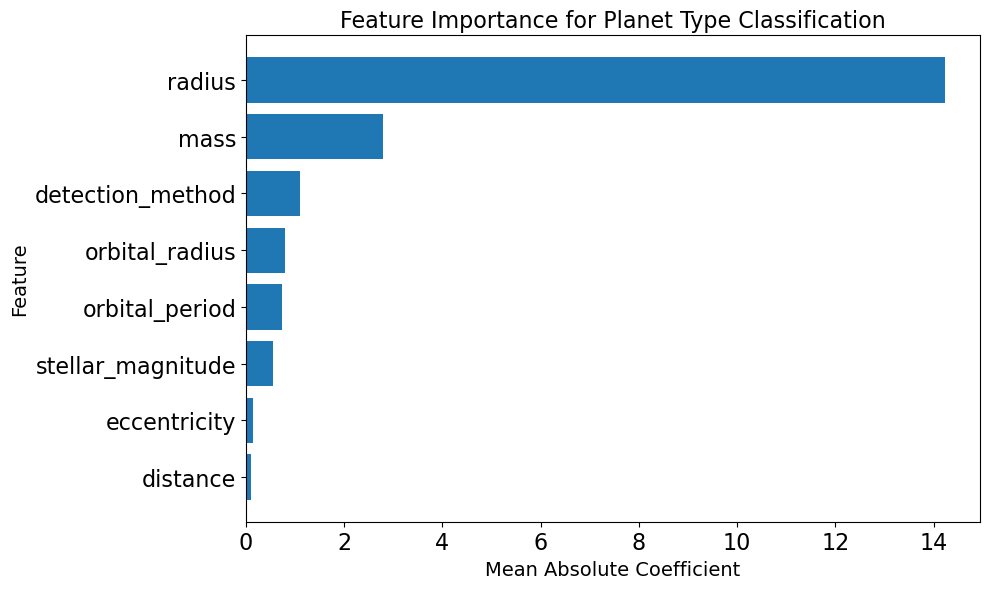

In [65]:
# Create DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': feature_importance
}).sort_values('Coefficient', ascending=False)

print(importance_df.to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Coefficient'])
plt.xlabel('Mean Absolute Coefficient', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance for Planet Type Classification', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Class 0: Gas Giant
          Feature  Coefficient
           radius    16.054542
             mass     4.624880
 detection_method    -0.934041
   orbital_radius     0.469025
stellar_magnitude     0.383015
     eccentricity     0.214442
         distance     0.180015
   orbital_period    -0.167390

Class 1: Neptune-like
          Feature  Coefficient
           radius    12.412312
             mass    -1.520276
 detection_method    -1.280814
   orbital_radius     0.847553
   orbital_period    -0.841068
stellar_magnitude     0.719266
         distance    -0.190722
     eccentricity     0.064667

Class 2: Super Earth
          Feature  Coefficient
           radius    -9.055414
   orbital_radius    -1.566807
   orbital_period     1.457897
             mass     0.935340
stellar_magnitude    -0.360505
 detection_method     0.094569
     eccentricity    -0.020341
         distance     0.017981

Class 3: Terrestrial
          Feature  Coefficient
           radius   -19.411440
             m

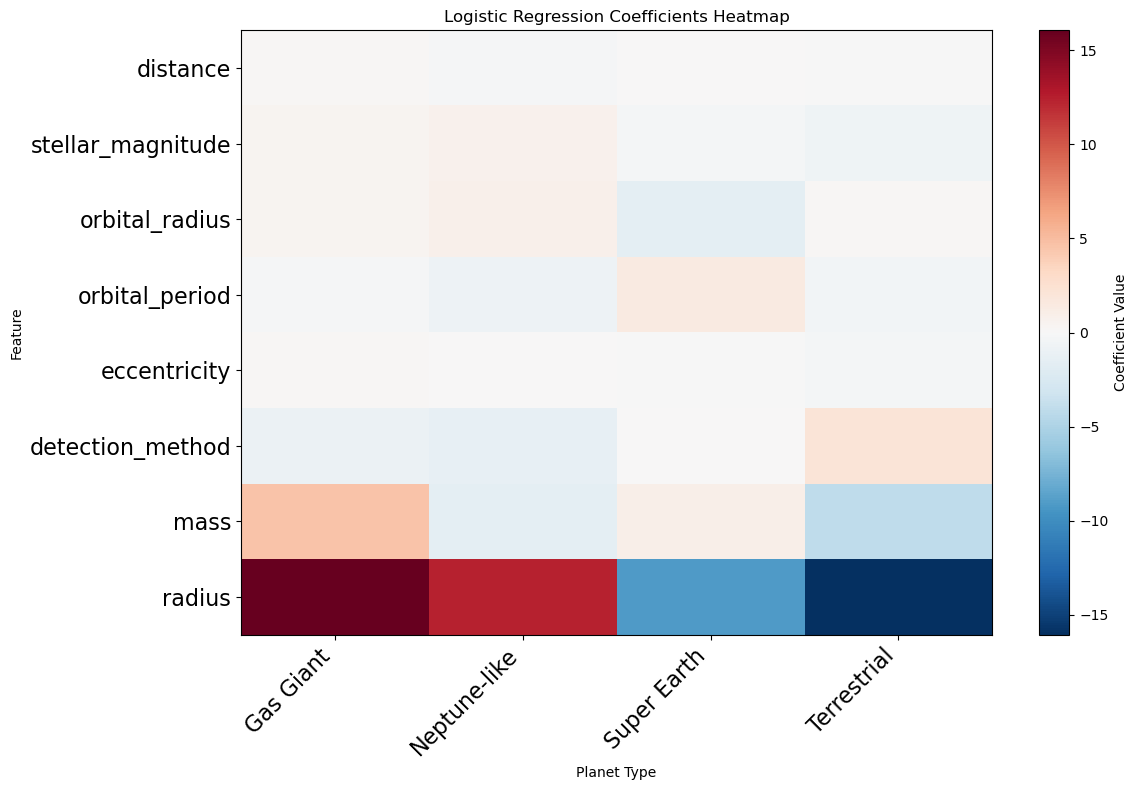

In [66]:
# Show coefficients for each class
for class_idx, class_name in enumerate(class_names):
    print(f"\nClass {class_idx}: {class_name}")
    class_coefs = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients[class_idx, :]
    }).sort_values('Coefficient', key=abs, ascending=False)
    print(class_coefs.to_string(index=False))

# Visualize coefficients heatmap
plt.figure(figsize=(12, 8))
plt.imshow(coefficients.T, aspect='auto', cmap='RdBu_r', vmin=-coefficients.max(), vmax=coefficients.max())
plt.colorbar(label='Coefficient Value')
plt.yticks(range(len(feature_names)), feature_names, fontsize=16)
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right', fontsize=16)
plt.xlabel('Planet Type')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients Heatmap')
plt.tight_layout()
plt.show()
